In [141]:
#Pour voir d'autre matchs juste à changer le path du fichier 

import pandas as pd
import json
from mplsoccer import Pitch
import matplotlib.pyplot as plt
import sys
sys.path.append('scripts')

with open('data/ligue1/3900490.json', 'r', encoding='utf-8') as f:
    data = json.load(f)
dataf = pd.DataFrame(data)
df = pd.json_normalize(data)
essai = df['team.name'].unique()

print(essai)


['Rennes' 'Paris Saint-Germain']


In [142]:
possession_time = df.groupby('team.name')['duration'].sum()

possession_total = possession_time.sum()
print(possession_total)

3859.431892141


In [143]:
possession_pct = round(possession_time/possession_total*100,2)

for equipe, poss in possession_pct.items():
    time = possession_time[equipe]
    minutes = int(time//60)
    secondes = int(time % 60)
    print(f'{equipe}: {poss}% avec {minutes}min {secondes}s')

Paris Saint-Germain: 60.98% avec 39min 13s
Rennes: 39.02% avec 25min 6s


In [144]:
def stat_team(df, team_name):
    df_team = df[df['team.name'] == team_name]

    stats = {'Équipe': team_name}
    # Score équipe
    shot = df_team[df_team['type.name'] == 'Shot']

    stats['Buts'] = len(shot[shot['shot.outcome.name'] == 'Goal'])

    # Possession des équipes
    stats['Possession (%)'] = round(df_team['duration'].sum()/df['duration'].sum()*100,1)

    # Nombre de tir

    stats['Tirs totaux'] = len(shot)
    stats['Tirs cadrés'] = len(shot[shot['shot.outcome.name'].isin(['Goal', 'Saved'])])
    stats['Tirs non cadrés'] = len(shot[shot['shot.outcome.name'].isin(['Off T', 'Post', 'Wayward', 'Saved To Post'])])
    stats['Tirs contrés'] = len(shot[shot['shot.outcome.name'].isin(['Blocked'])])
    stats['xG'] = round(shot['shot.statsbomb_xg'].sum(),1)

    #Passes
    nbr_pass = df_team[df_team['type.name'] == 'Pass']

    stats['Nombre de passes'] = len(nbr_pass)

    stats['Passes réussies'] = len(nbr_pass[nbr_pass['pass.outcome.name'].isna()])
    stats['Taux passe (%)'] = round(len(nbr_pass[nbr_pass['pass.outcome.name'].isna()])/ len(nbr_pass)*100,1)

    stats['Passes longues'] = len(nbr_pass[nbr_pass['pass.length'] >= 27])
    stats['Passes courtes'] = len(nbr_pass[nbr_pass['pass.length'] < 27])


    pass_loc = nbr_pass.dropna(subset=['location'])
    stats['Passes dernier tiers'] = len(pass_loc[pass_loc['location'].apply(lambda loc: loc[0] if isinstance(loc, list) else None)>90])

    stats['Passes clés'] = nbr_pass['pass.shot_assist'].notna().sum()

    #Centres
    nbr_centre = nbr_pass[nbr_pass['pass.cross'] == True]
    centre_reussi = nbr_centre[nbr_centre['pass.outcome.name'].isna()]

    stats['Centres'] = len(nbr_centre)
    stats['Centres réussis (%)'] = round(len(centre_reussi)/len(nbr_centre)*100,1) if len(nbr_centre) > 0 else 0    

    centre_loc = nbr_centre.dropna(subset=['location'])
    centre_reu_loc = centre_reussi.dropna(subset=['location'])

    stats['Centres droite'] = len(centre_loc[centre_loc['location'].apply(lambda loc: loc[1] if isinstance(loc, list) else None)>40])
    stats['Centres gauche'] = len(centre_loc[centre_loc['location'].apply(lambda loc: loc[1] if isinstance(loc, list) else None)<40])
    stats['Centres réussis droite (%)'] = round(len(centre_reu_loc[centre_reu_loc['location'].apply(lambda loc: loc[1] if isinstance(loc, list) else None)>40])/len(centre_loc[centre_loc['location'].apply(lambda loc: loc[1] if isinstance(loc, list) else None)>40])*100,1) if len(centre_reu_loc[centre_reu_loc['location'].apply(lambda loc: loc[1] if isinstance(loc, list) else None)>40])> 0 else 0
    stats['Centres réussis gauche (%)'] = round(len(centre_reu_loc[centre_reu_loc['location'].apply(lambda loc: loc[1] if isinstance(loc, list) else None)<40])/len(centre_loc[centre_loc['location'].apply(lambda loc: loc[1] if isinstance(loc, list) else None)<40])*100,1) if len(centre_reu_loc[centre_reu_loc['location'].apply(lambda loc: loc[1] if isinstance(loc, list) else None)<40]) > 0 else 0

    # Coup de pied arrêté
    nbr_corner = nbr_pass[nbr_pass['pass.type.name'] == 'Corner']
    nbr_coupfranc = nbr_pass[nbr_pass['pass.type.name'] == 'Free Kick']

    stats['Corners'] = len(nbr_corner)
    stats['Coup Franc'] = len(nbr_coupfranc) + len(shot[shot['shot.type.name'] == 'Free Kick'])

    #Hors jeu

    nbr_horsjeu = df_team[df_team['type.name'] == 'Offside']

    stats['Hors-jeu'] = len(nbr_horsjeu)

    #Fautes
    nbr_faute = df_team[df_team['type.name'] == 'Foul Committed']
    foul_won = df[df['type.name'] == 'Foul Won']

    stats['Fautes commises'] = len(nbr_faute)
    if 'foul_committed.card.name' in df_team.columns:
        stats['Cartons jaunes'] = len(df_team[df_team['foul_committed.card.name'] == 'Yellow Card'])
        stats['Cartons rouges'] = len(df_team[df_team['foul_committed.card.name'].isin(['Red Card', 'Second Yellow'])])
    else:
        stats['Cartons jaunes'] = 0
        stats['Cartons rouges'] = 0
    stats['Fautes subies'] = len(foul_won)

    if 'foul_won.penalty' in df_team.columns:
        nbr_penalty = df_team[df_team['foul_won.penalty'] == True]
        stats['Penalty'] = len(nbr_penalty)
    else:
        stats['Penalty'] = 0
    

    #Duels
    nbr_duel = df_team[df_team['type.name'] == 'Duel']
    nbr_duel_nettoyé = nbr_duel[nbr_duel['duel.outcome.name'].notna()]
    nbr_duelaerienper = len(nbr_duel[nbr_duel['duel.type.name'] == 'Aerial Lost'])
    nbr_duelaeriengag = len(df_team[(df_team.get('pass.aerial_won', pd.Series([False]*len(df_team))) == True) | (df_team.get('clearance.aerial_won', pd.Series([False]*len(df_team))) == True) | (df_team.get('shot.aerial_won', pd.Series([False]*len(df_team))) == True)])
    tacle = nbr_duel[nbr_duel['duel.type.name'] == 'Tackle']
    tacle_réussis = tacle[tacle['duel.outcome.name'].isin(['Success In Play', 'Won', 'Success Out'])]
    tacle_réussie_ratio = round(len(tacle_réussis)/len(tacle)*100,1) if len(tacle) > 0 else 0

    stats['Duel totaux'] = len(nbr_duel)
    stats['Duel gagnés (%)'] = round(len(nbr_duel_nettoyé[nbr_duel_nettoyé['duel.outcome.name'].isin(['Won','Success','Success In Play', 'Success Out'])])/len(nbr_duel_nettoyé)*100,1) if len(nbr_duel_nettoyé[nbr_duel_nettoyé['duel.outcome.name'].isin(['Won','Success','Success In Play', 'Success Out'])]) > 0 else 0

    stats['Duel aériens'] = nbr_duelaeriengag + nbr_duelaerienper
    stats['Duel aérien gagnés (%)'] = round(nbr_duelaeriengag/(nbr_duelaeriengag + nbr_duelaerienper)*100,1) if nbr_duelaeriengag > 0 else 0
    
    stats['Nombre de tacle'] = len(tacle)
    stats['Nombre de tacle réussi'] = len(tacle_réussis)
    stats['Pourcentage passe réussi (%)'] = tacle_réussie_ratio

    #Dribbles
    nbr_dribble = df_team[df_team['type.name'] == 'Dribble']
    nbr_dribblesucc = nbr_dribble[nbr_dribble['dribble.outcome.name'] == 'Complete']

    stats['Dribbles tentés'] = len(nbr_dribble) 
    stats['Dribbles réussis'] = len(nbr_dribblesucc)
    stats['Dribbles réussis (%)'] = round(len(nbr_dribblesucc)/len(nbr_dribble)*100,1) if len(nbr_dribblesucc) > 0 else 0

    #Actions défensives
    nbr_interception = df_team[df_team['interception.outcome.name'].isin(['Success', 'Success In Play', 'Success Out', 'Won'])]
    nbr_clear = df_team[df_team['type.name'] == 'Clearance']
    recuperation_total = df_team[df_team['type.name'] == 'Ball Recovery']
    recuperation_reussi = recuperation_total[recuperation_total['ball_recovery.recovery_failure'].isna()]
   
    stats['Interceptions'] = len(nbr_interception)
    stats['Dégagement'] = len(nbr_clear)

    if 'block.deflection' in df_team.columns:
        nbr_block = df_team[df_team['block.deflection'] == True]
        stats['Bloc'] = len(nbr_block)
    else :
        stats['Bloc'] = 0
    
    stats['Récupération'] = len(recuperation_reussi)
    
    #Arrêts
    nbr_save = df_team[df_team['goalkeeper.type.name'] == 'Shot Saved']
    df_team_adv = df[df['team.name'] != team_name]
    tirs_encaisse = df_team_adv[df_team_adv['type.name'] == 'Shot']
    tirs_cadre_encaisse = tirs_encaisse[tirs_encaisse['shot.outcome.name'].isin(['Goal', 'Saved'])]
    buts_encaisse = tirs_encaisse[tirs_encaisse['shot.outcome.name'] == 'Goal']
    clean_sheet = 0 if len(buts_encaisse) > 0 else 1
    
    stats['Arrêts'] = len(nbr_save)
    stats['Tirs subis'] = len(tirs_encaisse)
    stats['Tirs cadrés subis'] = len(tirs_cadre_encaisse)
    stats['Buts encaissés'] = len(buts_encaisse)
    stats['Clean sheet'] = clean_sheet

    return stats

teams = df['team.name'].unique()
all_stats = []

for team in teams:
    stats = stat_team(df, team)
    all_stats.append(stats)

stats_df = pd.DataFrame(all_stats)

print(stats_df.T)

                                   0                    1
Équipe                        Rennes  Paris Saint-Germain
Buts                               0                    1
Possession (%)                  39.0                 61.0
Tirs totaux                        6                   13
Tirs cadrés                        2                    5
Tirs non cadrés                    4                    6
Tirs contrés                       0                    2
xG                               0.3                  0.7
Nombre de passes                 441                  792
Passes réussies                  346                  687
Taux passe (%)                  78.5                 86.7
Passes longues                   102                  140
Passes courtes                   339                  652
Passes dernier tiers              38                   78
Passes clés                        4                   10
Centres                            7                   19
Centres réussi

In [145]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px

equipe1 = stats_df.iloc[0]
equipe2 = stats_df.iloc[1]

categorie = ['Possession (%)', 'xG', 'Tirs totaux', 'Tirs cadrés', 'Taux passe (%)', 'Centres', 'Duel gagnés (%)', 'Fautes commises']
categorie = categorie[::-1]
fig = go.Figure()

fig.add_trace(go.Bar(y=categorie, x=[-equipe1[cat] for cat in categorie], orientation ='h', name=equipe1['Équipe'], marker_color='blue', text= [equipe1[cat] for cat in categorie],  textposition='outside'))
fig.add_trace(go.Bar(y=categorie, x=[equipe2[cat] for cat in categorie], orientation ='h', name=equipe2['Équipe'], marker_color='red', text= [equipe2[cat] for cat in categorie],  textposition='outside'))

fig.update_layout(title=f'{equipe1["Équipe"]} {equipe1["Buts"]} - {equipe2["Buts"]} {equipe2["Équipe"]}', barmode='overlay', xaxis= dict(title='', showticklabels=False, zeroline=True, zerolinewidth=2))

fig.show()

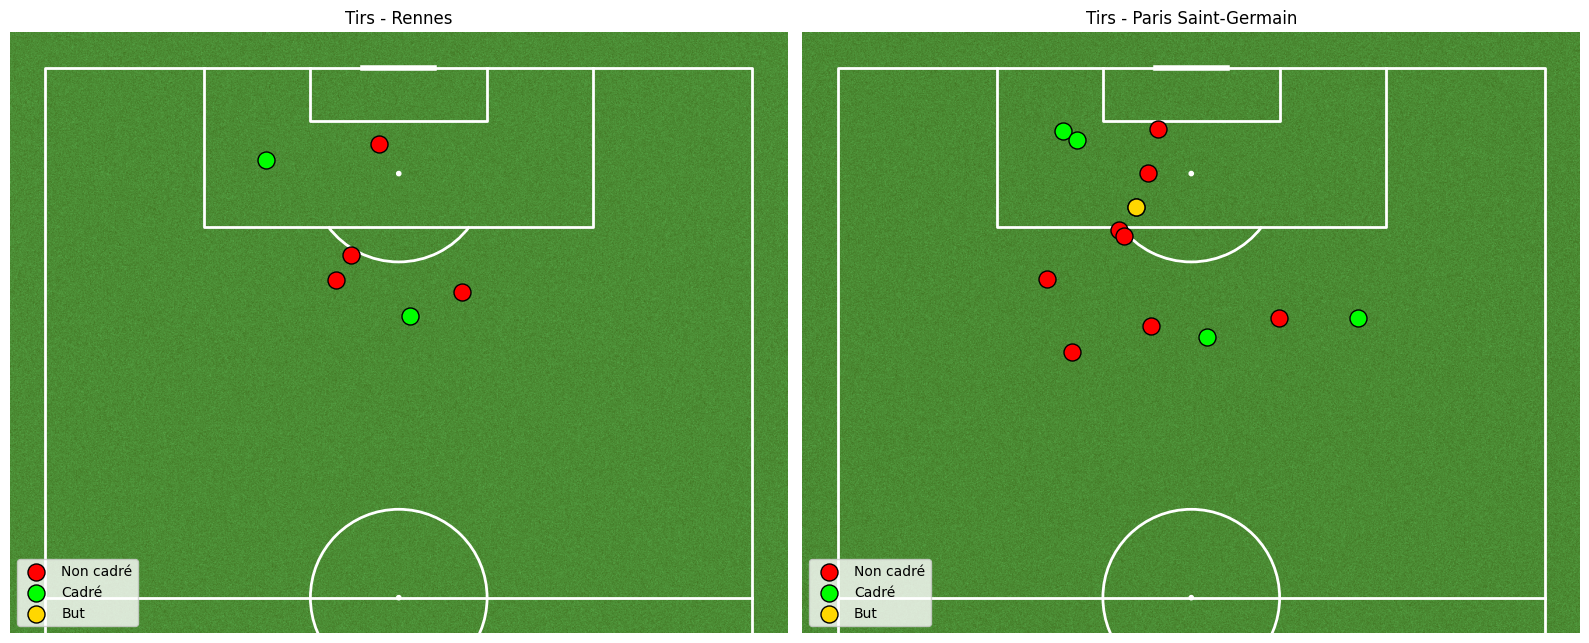

In [146]:
from mplsoccer import Pitch, VerticalPitch
import matplotlib.pyplot as plt

shot = df[df['type.name'] == 'Shot'].copy()
shot['cadre'] = shot['shot.outcome.name'].isin(['Saved'])
shot['goal'] = shot['shot.outcome.name'].isin(['Goal'])

equipe1_name = df['team.name'].unique()[0]
equipe2_name = df['team.name'].unique()[1]

shot1 = shot[shot['team.name'] == equipe1_name]
shot1cadre = shot1[shot1['cadre'] == True]
shot1noncadre = shot1[shot1['cadre'] == False]
shot1goal = shot1[shot1['goal'] == True]

shot2 = shot[shot['team.name'] == equipe2_name]
shot2cadre = shot2[shot2['cadre'] == True]
shot2noncadre = shot2[shot2['cadre'] == False]
shot2goal = shot2[shot2['goal'] == True]


def getcoord(df_shot):
    x = df_shot['location'].apply(lambda loc: loc[0] if isinstance(loc, list) else None)
    y = df_shot['location'].apply(lambda loc: loc[1] if isinstance(loc, list) else None)
    return x,y

x, y = getcoord(shot1cadre)

fig, axes = plt.subplots(1,2, figsize=(16,8))

pitch1 = VerticalPitch(pitch_type='statsbomb', half=True, pitch_color='grass', line_color='white')
pitch1.draw(ax=axes[0])
x, y = getcoord(shot1noncadre)
pitch1.scatter(x, y, ax=axes[0], color='red', s=150, edgecolor='black', linewidth=1, label="Non cadré", zorder=2)
x, y = getcoord(shot1cadre)
pitch1.scatter(x, y, ax=axes[0], color='lime', s=150, edgecolor='black', linewidth=1, label="Cadré", zorder=2)
x, y = getcoord(shot1goal)
pitch1.scatter(x, y, ax=axes[0], color='gold', s=150, edgecolor='black', linewidth=1, label="But", zorder=2)

axes[0].set_title(f'Tirs - {equipe1_name}', fontsize=12)
axes[0].legend(loc='lower left')

pitch2 = VerticalPitch(pitch_type='statsbomb', half=True, pitch_color='grass', line_color='white')
pitch2.draw(ax=axes[1])
x, y = getcoord(shot2noncadre)
pitch1.scatter(x, y, ax=axes[1], color='red', s=150, edgecolor='black', linewidth=1, label="Non cadré", zorder=2)
x, y = getcoord(shot2cadre)
pitch1.scatter(x, y, ax=axes[1], color='lime', s=150, edgecolor='black', linewidth=1, label="Cadré", zorder=2)
x, y = getcoord(shot2goal)
pitch1.scatter(x, y, ax=axes[1], color='gold', s=150, edgecolor='black', linewidth=1, label="But", zorder=2)

axes[1].set_title(f'Tirs - {equipe2_name}', fontsize=12)
axes[1].legend(loc='lower left')


plt.tight_layout()
plt.show()

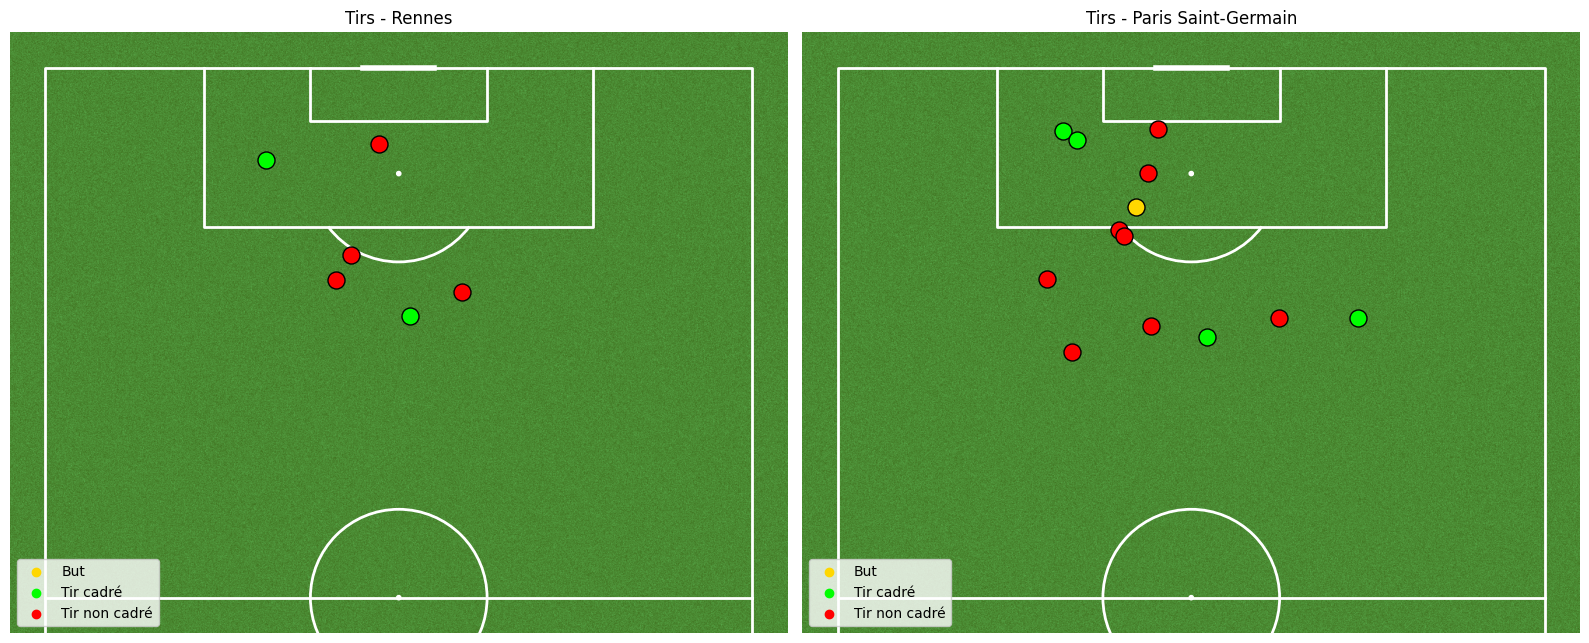

In [147]:
teams = df['team.name'].unique()

fig, axes= plt.subplots(1, 2, figsize=(16,8))

row = df[df['type.name'] == 'Shot']


for idx,team in enumerate(teams):
    pitch = VerticalPitch(half=True, pitch_type='statsbomb', pitch_color='grass', line_color='white')
    pitch.draw(ax=axes[idx])

    team_shot = row[row['team.name'] == team]

    for i, shot in team_shot.iterrows():
        outcome = shot['shot.outcome.name']
        x, y = shot['location']
        if outcome == 'Goal' :
            pitch.scatter(x,y, ax=axes[idx], color='gold', edgecolor='black', s=150, linewidth=1, zorder=2)
        elif outcome == 'Saved' : 
            pitch.scatter(x,y, ax=axes[idx], color='lime', edgecolor='black', s=150, linewidth=1, zorder=2)
        else :
            pitch.scatter(x,y, ax=axes[idx], color='red', edgecolor='black', s=150, linewidth=1, zorder=2)
    
    axes[idx].scatter([], [], color='gold', label='But')
    axes[idx].scatter([], [], color='lime', label='Tir cadré')
    axes[idx].scatter([], [], color='red', label='Tir non cadré')

    axes[idx].legend(loc='lower left')
    axes[idx].set_title(f'Tirs - {team}')
plt.tight_layout()
plt.show()


       

In [148]:
colonnes_card = [col for col in df.columns if 'card' in col.lower()]

print(colonnes_card)
#print(df['foul_committed.card.name'].unique())
#print(df['foul_committed.card.name'].value_counts())

#yellow_card = df[df['foul_committed.card.name'] == 'Yellow Card']
#red_card = df[df['foul_committed.card.name'].isin(['Red Card', 'Second Yellow'])]
print(yellow_card)
print(len(red_card))

[]
                                        id  index  period     timestamp  \
324   321e866d-28c7-4703-9d5f-0848fa5d96ad    325       1  00:07:39.165   
601   7ef124ba-6767-4901-8713-ebcdb9b4f8a1    602       1  00:16:41.115   
1031  b3e3081c-e083-48ea-9635-9de33a9c30c6   1032       1  00:26:10.781   

      minute  second  possession  duration  type.id       type.name  ...  \
324        7      39          25       0.0       22  Foul Committed  ...   
601       16      41          41       0.0       22  Foul Committed  ...   
1031      26      10          64       0.0       22  Foul Committed  ...   

      shot.aerial_won pass.goal_assist  pass.no_touch shot.one_on_one  \
324               NaN              NaN            NaN             NaN   
601               NaN              NaN            NaN             NaN   
1031              NaN              NaN            NaN             NaN   

      pass.deflected block.save_block  goalkeeper.success_in_play  \
324              NaN         

In [149]:
foul_type = [t for t in df['type.name'].unique() if 'Foul' in str(t)]
print(foul_type)

foul_won = df[df['type.name'] == 'Foul Won']
print(len(foul_won))

['Foul Committed', 'Foul Won']
23


In [150]:
tacle_types = [t for t in df['type.name'].unique() if 'Tackle' in str(t) or 'Duel' in str(t)]

print(tacle_types)

colonnes_tacle = [col for col in df.columns if 'tackle' in col.lower()]
print(colonnes_tacle)

duels = df[df['type.name'] == 'Duel']
print(duels['duel.type.name'].unique())

tacle = duels[duels['duel.type.name'] == 'Tackle']
print(len(tacle))
print(tacle['duel.outcome.name'].value_counts())

tacle_réussis = tacle[tacle['duel.outcome.name'].isin(['Success In Play', 'Won', 'Success Out'])]
tacle_réussie_ratio = round(len(tacle_réussis)/len(tacle)*100,1) if len(tacle) > 0 else 0

print(tacle_réussie_ratio)

['Duel']
[]
['Tackle' 'Aerial Lost']
44
duel.outcome.name
Won                15
Success In Play    13
Lost In Play        8
Lost Out            7
Success Out         1
Name: count, dtype: int64
65.9


In [151]:
récupération_de_balle = [t for t in df['type.name'].unique() if 'Ball' in str(t) or 'Recovery' in str(t)]

print(récupération_de_balle)

recuperation_total = df[df['type.name'] == 'Ball Recovery']
recuperation_reussi = recuperation_total[recuperation_total['ball_recovery.recovery_failure'].isna()]

print(recuperation_total['ball_recovery.recovery_failure'].value_counts(dropna=False))
print(len(recuperation_reussi))


colonne_recup = [col for col in df.columns if 'ball_recovery' in col.lower()]
print(colonne_recup)

['Ball Receipt*', 'Ball Recovery']
ball_recovery.recovery_failure
NaN     102
True      9
Name: count, dtype: int64
102
['ball_recovery.recovery_failure']


In [152]:
team_name = 'Lille'

df_team_adv = df[df['team.name'] != team_name]

tirs_encaisse = df_team_adv[df_team_adv['type.name'] == 'Shot']
tirs_cadre_encaisse = tirs_encaisse[tirs_encaisse['shot.outcome.name'].isin(['Goal', 'Saved'])]
buts_encaisse = tirs_encaisse[tirs_encaisse['shot.outcome.name'] == 'Goal']
clean_sheet = 0 if len(buts_encaisse) > 0 else 1

print(len(tirs_encaisse))
print(len(tirs_cadre_encaisse))
print(len(buts_encaisse))




19
7
1


In [153]:
equipes = df[df['type.name'] == 'Starting XI']['team.name'].tolist()

print(equipes)



['Rennes', 'Paris Saint-Germain']


In [159]:

from importlib import reload
import fonction
reload(fonction)

test = fonction.stat_match('data/ligue1/3900490.json')

print(test)

[{'Équipe': 'Rennes', 'Buts': 0, 'Possession (%)': np.float64(39.0), 'Tirs totaux': 6, 'Tirs cadrés': 2, 'Tirs non cadrés': 4, 'Tirs contrés': 0, 'xG': np.float64(0.3), 'Nombre de passes': 441, 'Passes réussies': 346, 'Taux passe (%)': 78.5, 'Passes longues': 102, 'Passes courtes': 339, 'Passes dernier tiers': 38, 'Passes clés': np.int64(4), 'Centres': 7, 'Centres réussis (%)': 14.3, 'Centres droite': 2, 'Centres gauche': 5, 'Centres réussis droite (%)': 0, 'Centres réussis gauche (%)': 20.0, 'Corners': 1, 'Coup Franc': 13, 'Hors-jeu': 0, 'Fautes commises': 15, 'Cartons jaunes': 0, 'Cartons rouges': 0, 'Fautes subies': 23, 'Penalty': 0, 'Duel totaux': 38, 'Duel gagnés (%)': 52.4, 'Duel aériens': 33, 'Duel aérien gagnés (%)': 48.5, 'Nombre de tacle': 21, 'Nombre de tacle réussi': 11, 'Pourcentage passe réussi (%)': 52.4, 'Dribbles tentés': 17, 'Dribbles réussis': 11, 'Dribbles réussis (%)': 64.7, 'Interceptions': 7, 'Dégagement': 37, 'Bloc': 0, 'Récupération': 58, 'Arrêts': 4, 'Tirs sub

In [161]:
reload(fonction)

test_total = fonction.stat_tous_matchs('data/ligue1')

print(f'{len(test_total)} matchs chargés')

534 matchs chargés


In [163]:
csv = fonction.stat_tous_matchs('data/ligue1').to_csv('outputs/stats_tous_matchs.csv', index=False)

csv

